In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        res = res.applymap(float_to_percent)
        return res

    ret = adjnav.pct_change()
    #annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()

# Define a formatting function to convert float to percentage
def float_to_percent(x):
    return "{:.2%}".format(x)


In [91]:
from sklearn.linear_model import LinearRegression
# Training Linear Regression based on 2018-2022 data
Year = 2015
End_Year = 2022
index_data = pd.read_csv('USD ETFs_open.csv')
index_data['Year'] = index_data['datetime'].apply(lambda x: int(x.split('-')[0]))
# index_data =  index_data[index_data['Year']>=Year]
index_data = index_data.set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

index_id = 'SPY'

df = index_data.loc[:,[index_id,'Year']]
# adding feature
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df = df.rename({index_id:'Price'},axis=1)
df['SMA_10'] = df['Price'].rolling(window=10).mean()
df['SMA_50'] = df['Price'].rolling(window=50).mean()
df['Forecast'] = df['Price'].shift(-1) # Dependent variable
df = df.loc[df[['SMA_10', 'SMA_50']].dropna().index]
X = df[['SMA_10', 'SMA_50']] # Independent variables
y = df['Forecast'] # Dependent variable

# Split data into training and test sets
train_size = int(len(df[df['Year']<=End_Year]) * 0.8)
test_size = int(len(df[df['Year']<=End_Year]))
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:test_size], y[train_size:test_size]

# Fit linear regression model to training data
lr = LinearRegression()
lr.fit(train_X, train_y)

# Make predictions on test data
y_pred = lr.predict(test_X)

# Get the Robustnes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Evaluate performance on testing dataset
r2 = r2_score(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
mse = mean_squared_error(test_y, y_pred)

print("R2 score on testing dataset: ", r2)
print("MAE on testing dataset: ", mae)
print("MSE on testing dataset: ", mse)

# Add in prediction
df['Predicted'] = lr.predict(np.array(X).reshape(-1, len(X.columns)))
df

R2 score on testing dataset:  0.9808617774991039
MAE on testing dataset:  6.215823241055683
MSE on testing dataset:  72.56603221388089


/Users/noahyao/miniforge3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Price,Year,ret,asset,SMA_10,SMA_50,Forecast,Predicted
2005-03-15,85.358922,2005,0.006716,0.998848,85.507266,84.126569,84.149728,85.769488
2005-03-16,84.149728,2005,-0.014166,0.984698,85.432744,84.100416,83.875584,85.689874
2005-03-17,83.875584,2005,-0.003258,0.981490,85.267538,84.084247,84.063877,85.509041
2005-03-18,84.063877,2005,0.002245,0.983694,85.093741,84.096027,83.781577,85.315819
2005-03-21,83.781577,2005,-0.003358,0.980390,84.848832,84.106379,83.541629,85.044183
...,...,...,...,...,...,...,...,...
2023-05-08,412.970001,2023,0.009929,4.832468,410.619995,402.892409,411.130005,411.864273
2023-05-09,411.130005,2023,-0.004456,4.810937,410.674997,403.148016,413.880005,411.898518
2023-05-10,413.880005,2023,0.006689,4.843117,411.390997,403.511221,411.950012,412.651832
2023-05-11,411.950012,2023,-0.004663,4.820533,411.885999,403.872088,413.420013,413.161242


,AnnRet,AnnVol,SR,MaxDD,Calmar
asset,22.62%,15.97%,141.59%,-7.97%,283.88%
stgy,49.93%,14.29%,349.41%,-3.48%,1435.49%


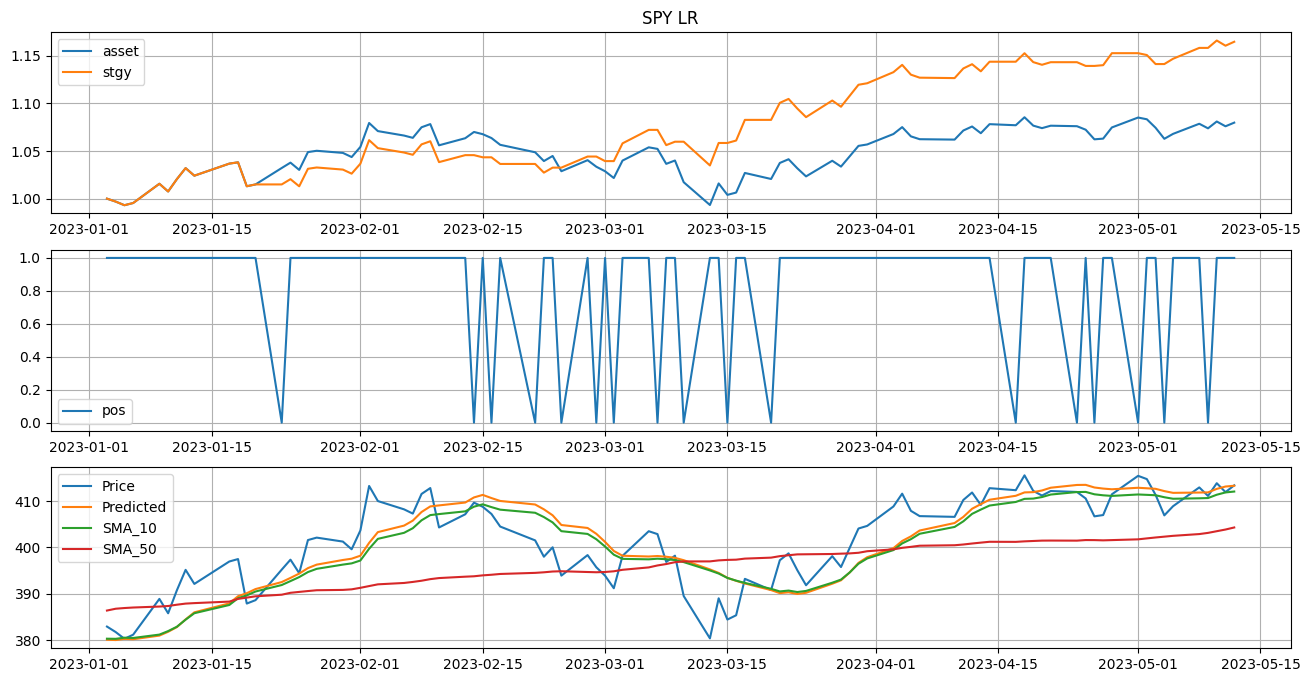

In [99]:
# Set up long/short strategy based on predicted returns
df = df[df['Year']>=2023]
df['ret'] = df['Price'].pct_change()
df['Buy/Sold Price'] = df['Price'].shift(1)
df['asset'] = (1+df['ret']).cumprod().fillna(1)
tolarent = 0.01
signal = 0
price = 0
def position(x):
    global signal
    global price
    if signal == 0:
        if x['Price'] / x['Predicted'] < 1:
            signal = 1 
            price = x['Price']
            return 1
    if signal == 1:
        if (x['Price'] < x['Buy/Sold Price'] and x['Price'] < x['Predicted']) | (x['Buy/Sold Price'] > price):
            signal = 0
            price = 0
            return 0
    return 1
df['pos'] = df.apply(position,axis=1)
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(3,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title=f'{index_id} LR')
ax2 = fig.add_subplot(3,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
ax3 = fig.add_subplot(3,1,3)
df.loc[:,['Price','Predicted','SMA_10','SMA_50']].plot(ax=ax3, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
display(res)


,AnnRet,AnnVol,SR,MaxDD,Calmar
asset,22.62%,15.97%,141.59%,-7.97%,283.88%
stgy,-28.04%,9.44%,-297.17%,-11.64%,-240.92%


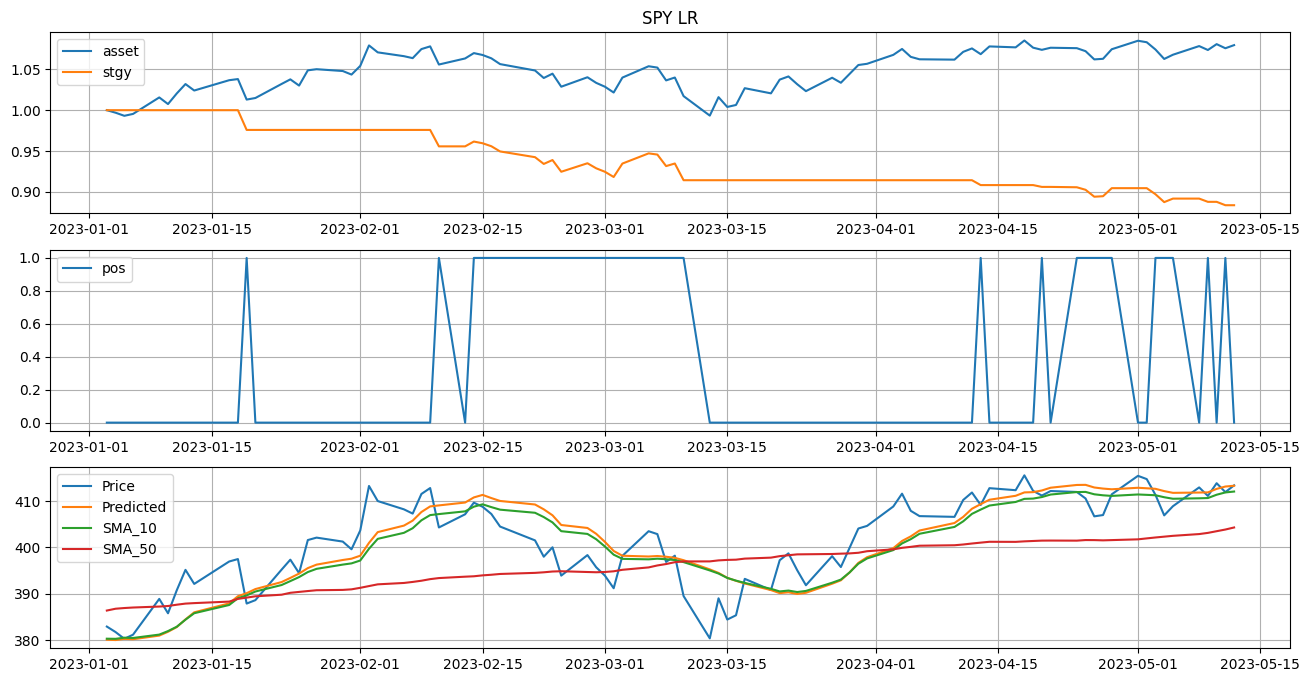

In [100]:
# Set up long/short strategy based on predicted returns
df = df[df['Year']>=2023]
df['Last Day Price'] = df['Price'].shift(1)
tolarent = 0.01
signal = 1
price = df['Price'].tolist()[0]
def position(x):
    global signal
    global price
    x['Buy/Sold'] = x['Price']
    x['pos'] = signal
    if signal == 0:
        if x['Price'] / x['Predicted'] < 1:
            signal = 1 
            price = x['Price']
            x['pos'] = signal
            x['Buy/Sold'] = price
    if signal == 1:
        if x['Price'] / price >1 or x['Predicted']/x['SMA_50']<1:
            signal = 0
            price = x['Price']
            x['Buy/Sold'] = price
            x['pos'] = signal
    return x
df = df.apply(position,axis=1)
df['ret'] = df['Price'].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['stgy_ret'] = df['Buy/Sold'].pct_change() * df['pos']
# df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(3,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title=f'{index_id} LR')
ax2 = fig.add_subplot(3,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
ax3 = fig.add_subplot(3,1,3)
df.loc[:,['Price','Predicted','SMA_10','SMA_50']].plot(ax=ax3, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
display(res)


In [78]:
df

,Price,Year,ret,asset,SMA_10,SMA_50,Forecast,Predicted,Last Day Price,Buy/Sold,pos,stgy_ret,stgy
2023-01-03,382.908622,2023.0,NaN,1.000000,380.289624,386.370587,381.723152,380.071120,NaN,382.908622,1.0,NaN,1.000000
2023-01-04,381.723152,2023.0,-0.003096,0.996904,380.260733,386.763667,380.268691,379.998423,382.908622,382.908622,1.0,0.000000,1.000000
2023-01-05,380.268691,2023.0,-0.003810,0.993106,380.508784,386.914057,381.155288,380.256852,381.723152,382.908622,1.0,0.000000,1.000000
2023-01-06,381.155288,2023.0,0.002332,0.995421,380.445024,387.024663,388.885812,380.174939,380.268691,382.908622,1.0,0.000000,1.000000
2023-01-09,388.885812,2023.0,0.020282,1.015610,381.174243,387.233753,385.777675,380.958846,381.155288,388.885812,0.0,0.015610,1.015610
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08,412.970001,2023.0,0.009929,1.078508,410.619995,402.892409,411.130005,411.864273,408.910004,411.359985,1.0,0.000000,1.067924
2023-05-09,411.130005,2023.0,-0.004456,1.073703,410.674997,403.148016,413.880005,411.898518,412.970001,411.359985,1.0,0.000000,1.067924
2023-05-10,413.880005,2023.0,0.006689,1.080885,411.390997,403.511221,411.950012,412.651832,411.130005,413.880005,0.0,0.006126,1.074466
2023-05-11,411.950012,2023.0,-0.004663,1.075844,411.885999,403.872088,413.420013,413.161242,413.880005,411.950012,1.0,-0.000000,1.074466


In [ ]:
# test on ETF Pool

# Long short on the highest varaiance

